# Grass et les rasters

## Création de la session jupyter pour le workshop

Dans les parties précédentes, nous avons réalisé la création du jeu de données.
Nous allons maintenant configurer Jupyter pour utiliser les modules grass en python. Les commandes unix ou windows seront données après les commandes python Jupyter.

Le code suivant va charger les modules grass et ouvre la session grass avec le Jeu de données `megeve\urbanisme`



In [1]:
# Import Python standard library and IPython packages we need.
import subprocess
import sys

# Ask GRASS GIS where its Python packages are.
sys.path.append(
    subprocess.check_output(["grass", "--config", "python_path"], text=True).strip()
)

# Import the GRASS GIS packages we need.
import grass.script as gs
import grass.jupyter as gj

# Start GRASS Session
session = gj.init("~/grassdata", "megeve", "urbanisme")

# Defines datadir
from pathlib import Path
import os
datadir = os.getcwd() / Path('data')

C'est l'équivalent de :


Unix :

```
grass $HOME/grassdata/megeve/urbanisme
```

Windows :

```
C:\OSGeo4W\bin\grass83.bat %HOMEPATH%\grassdata\megeve\urbanisme
```

Il y a deux APIs Python pour accéder aux outils - [GRASS GIS Python Scripting Library](https://grass.osgeo.org/grass-stable/manuals/libpython/script_intro.html) et [PyGRASS](https://grass.osgeo.org/grass-stable/manuals/libpython/pygrass_index.html).
PyGRASS est plus intéressant pour les processus avancés. Ici, nous utiliserons le Python Scripting Library (`import grass.script as gs`)
puisqu'il est simple et facile à utiliser.


La bibliothèque de scripting Python de GRASS GIS fournit des fonctions pour appeler les modules GRASS au sein de scripts en tant que sous-processus. Les fonctions les plus couramment utilisées comprennent :

* [run_command()](https://grass.osgeo.org/grass-stable/manuals/libpython/script.html#script.core.run_command) : utilisée avec des modules qui produisent des données raster/vectorielles où une sortie textuelle n'est pas attendue.
* [read_command()](https://grass.osgeo.org/grass-stable/manuals/libpython/script.html#script.core.read_command) : utilisée lorsque nous sommes intéressés par la sortie textuelle.
* [parse_command()](https://grass.osgeo.org/grass-stable/manuals/libpython/script.html#script.core.parse_command) : utilisée avec des modules produisant une sortie textuelle sous forme de paire clé=valeur.
* [write_command()](https://grass.osgeo.org/grass-stable/manuals/libpython/script.html#script.core.write_command) : pour les modules qui attendent une entrée textuelle à partir de l'entrée standard ou d'un fichier.

Il fournit également plusieurs fonctions enveloppantes pour les modules fréquemment appelés. La liste des fonctions enveloppantes pratiques avec des exemples comprend :

* Métadonnées raster en utilisant [raster_info()](https://grass.osgeo.org/grass-stable/manuals/libpython/script.html#script.raster.raster_info) : `gs.raster_info('dsm')`
* Métadonnées vectorielles en utilisant [vector_info()](https://grass.osgeo.org/grass-stable/manuals/libpython/script.html#script.vector.vector_info) : `gs.vector_info('roads')`
* Liste des données raster dans l'emplacement actuel en utilisant [list_grouped()](https://grass.osgeo.org/grass-stable/manuals/libpython/script.html#script.core.list_grouped) : `gs.list_grouped(type=['raster'])`
* Obtenir la région de calcul actuelle en utilisant [region()](https://grass.osgeo.org/grass-stable/manuals/libpython/script.html#script.core.region) : `gs.region()`
* Exécuter une algèbre raster en utilisant [mapcalc()](https://grass.osgeo.org/grass-stable/manuals/libpython/script.html#script.raster.mapcalc) : `gs.mapcalc()`

## Inondation / Création d'un lac

On souhaite étudier la création d'un lac, ou le volume nécessaire pour innonder une position. Quel volume d'eau ai-je besoin pour une hauteur de 2 mètres ?


Mes 3 points : 

- COORD=1979128.5,5189251.3
- COORD=1983615,5186469
- COORD=1981568,5189641

Les étapes à suivre :
- importer le mnt `r.in.gdal`
- Définition de la région sur le mnt `g.region`
- Création du lac `r.lake` Attention water_level nécessite d'avoir un Z > à celui de la coordonnée [1] (interrogation avec `r.what` [2] et on peut scripter avec `awk`) [1]
- Création du relief `r.relief`
- Création de la carte `d.mon` et `d.rast`

[1]
Si on tente de faire un lac de 5 m profond on va avoir ce genre d'erreur :

```
> r.lake elevation=mnt coordinates=1979128.5,5189251.3 water_level=5 lake=flood
ERREUR : Given water level at seed point is below earth surface. Increase
         water level or move seed point.
```

[2] 
```
> r.what mnt coordinates=1979128.5,5189251.3
1979128.5|5189251.3||1047.95349470892
```

In [4]:
gs.run_command("r.in.gdal", input=datadir / "mnt_4m.tif", output="mnt")
gs.run_command("g.region", raster="mnt") # ou g.region raster=mnt
gs.run_command("r.relief", input="mnt", output="mnt_relief")

In [19]:
coords = ['1979128.5,5189251.3', '1983615,5186469', '1981568,5189641']
lac_number = 1
water_level = 2
for coord in coords:
    res_what = gs.read_command('r.what', map='mnt', coordinates=coord)
    fond = float(res_what.split('|')[1]) - water_level
    lac_name = 'lac' + str(lac_number)
    gs.run_command('r.lake', elevation='mnt', water_level=fond, lake=lac_name, coordinates=coord, overwrite=True)
    lac_number += 1


*Solution (sur unix):*

```
r.in.gdal $HOME/data/mnt_4m.tif output=mnt`
g.region rows=433 cols=483 # ou g.region raster=mnt
r.relief input=mnt output=mnt_relief
COORD=1979128.5,5189251.3
elevation=`r.what mnt coordinates=${COORD} | awk -F '|' '{print $4}'`
r.lake elevation=mnt coordinates=${COORD} water_level=`echo $elevation+2 | bc` lake=flood
```

### Écoulement

Je souhaite calculer deux écoulements sur deux points.- 

point 1 : 1978719.6, 51917
- 7.3
point 2 : 1983615, 518

Les étapes :
6469

- Création d'une couche point avec `v.in.ascii`
- Création de l'écoulement avec `r.drain`
- Création de la carte `d.mon`, `d.shade`, `d.vect` et `d.legend`


In [23]:
points=["1978719.6,5191787.3", "1983615,5186469"]
with open("/tmp/points", "w") as f:
    f.writelines(points)

*Solution :*
Unix. 
Création d'une table avec les poin :
ts
```
v.in.ascii input=- output=start format=point separator=comma <<EOF
1978719.6,5191787.3
1983615,5186469
EOF
```

ou sur windows : 
Créer un fichier avec les coordonées
er
et  : 'import avec 

`v.%HOMEPATH%\Users\oslandia\data\points.csv output=start separator=comma`

In [24]:
# Création d'une couche "start" depuis les points daans le fichier
gs.run_command("v.in.ascii", input="/tmp/points", output="start", separator="comma")
# Création de l'écoulement
gs.run_command("r.drain", input="mnt", output="drain_path", drain="drain", start_points="start")
# Création de la couleur du mnt
gs.run_command("r.colors", map="mnt", color="elevation")

In [26]:
%%bash
d.mon start=cairo output=$HOME/grass_png/ex_raster_drain.png 
# ou d.mon wx0
d.shade shade=mnt_relief color=mnt
d.vect map=drain color=0:0:61 width=4 legend_label="drainage paths"
d.vect map=start color=none fill_color=224:0:0 icon=basic/circle size=15 legend_label=origins
d.legend.vect -b
d.mon stop=cairo

   0   3   6   9  12  15  18  21  24  27  30  33  36  39  42  45  48  51  54  57  60  63  66  69  72  75  78  81  84  87  90  93  96  99 100
d.vect complete.
d.vect complete.


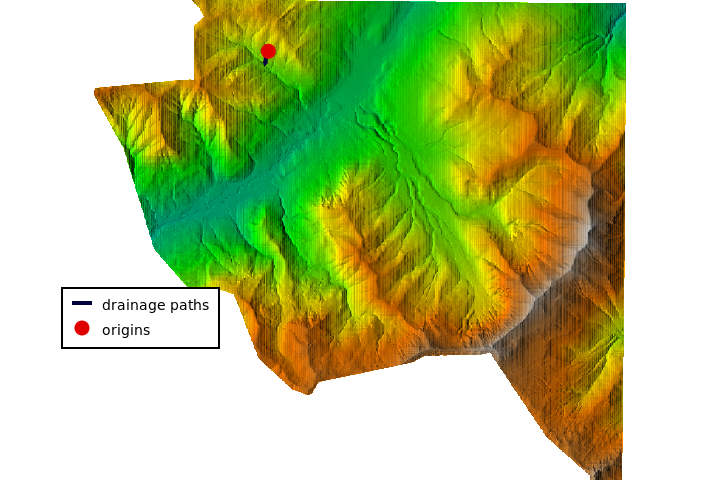

In [27]:
# On utilise IPython pour afficher l'image dans le notebooks
from IPython.display import Image, display
import os
from pathlib import Path
display(Image(filename=Path(os.getenv('HOME')) / 'grass_png' / 'ex_raster_drain.png'))

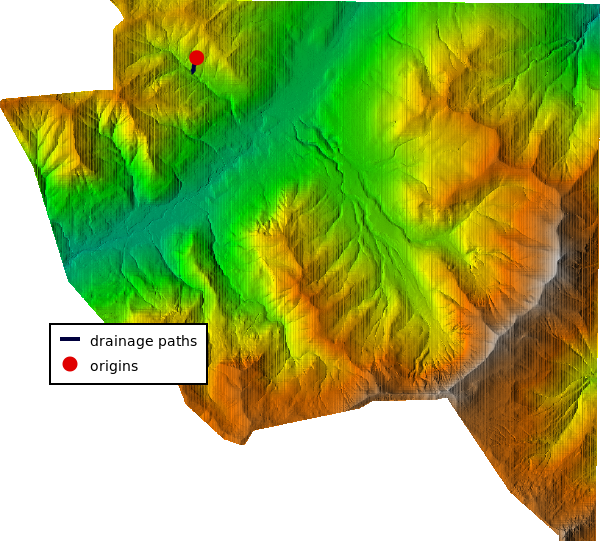

In [30]:
# ou directement avec Grass Jupyter
# Instanciation de la carte
hexa_map = gj.Map()
# Ajout des hexagons et des commerces
hexa_map.run("d.shade", shade="mnt_relief", color="mnt")
hexa_map.d_vect(map="drain", color="0:0:61", width=4, legend_label="drainage paths")
hexa_map.d_vect(map="start", color="none", fill_color="224:0:0", icon="basic/circle", size=15, legend_label="origins")
hexa_map.run("d.legend.vect", flags="b")
# Display map
hexa_map.show()

Toutefois, cela ne va pas jusqu'à la mer, cela s'arrête au premier point bas.
On va utiliser le module de calcul hydrologique `r.watershed` pour réaliser cela. Il faut utiliser une formule "bien connue" (hmmm...) en utilisant la calculatrice raster `r.mapcalc`

Maintenant on peut refaire la carte

In [31]:
%%bash
r.watershed elevation=mnt accumulation=accum drainage=drain_dir
r.mapcalc "drain_deg = if(drain_dir != 0, 45. * abs(drain_dir), null())"
r.mapcalc "const1 = 1"
r.drain -d input=const1 direction=drain_deg output=drain_path_2 drain=drain_2 start_points=start

SECTION 1a (of 4): Initiating Memory.
SECTION 1b (of 4): Determining Offmap Flow.
   0   4   8  12  16  20  24  28  32  36  40  44  48  52  56  60  64  68  72  76  80  84  88  92  96 100
SECTION 2: A* Search.
   0   2   4   6   8  10  12  14  16  18  20  22  24  26  28  30  32  34  36  38  40  42  44  46  48  50  52  54  56  58  60  62  64  66  68  70  72  74  76  78  80  82  84  86  88  90  92  94  96  98 100
SECTION 3a: Accumulating Surface Flow with MFD.
   1   3   5   7   9  11  13  15  17  19  21  23  25  27  29  31  33  35  37  39  41  43  45  47  49  51  53  55  57  59  61  63  65  67  69  71  73  75  77  79  81  83  85  87  89  91  93  95  97  99 100
SECTION 3b: Adjusting drainage directions.
   1   3   5   7   9  11  13  15  17  19  21  23  25  27  29  31  33  35  37  39  41  43  45  47  49  51  53  55  57  59  61  63  65  67  69  71  73  75  77  79  81  83  85  87  89  91  93  95  97  99 100
SECTION 4: Closing Maps.
Writing output raster map...
   0   3   6   9  12  15  18  2

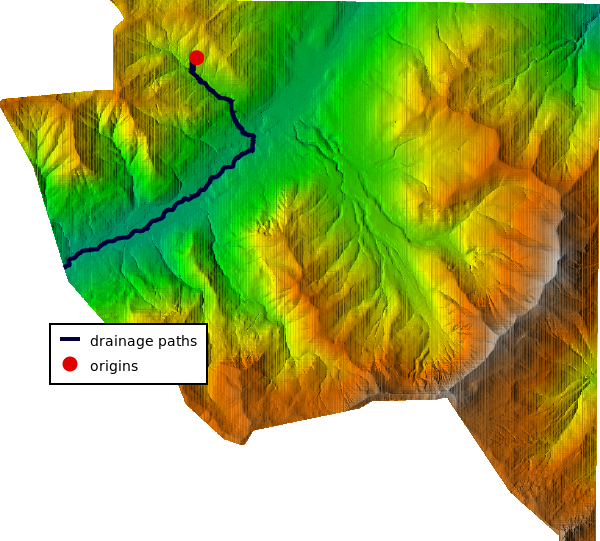

In [33]:
# ou directement avec Grass Jupyter
# Instanciation de la carte
hexa_map = gj.Map()
# Ajout des hexagons et des commerces
hexa_map.run("d.shade", shade="mnt_relief", color="mnt")
hexa_map.d_vect(map="drain_2", color="0:0:61", width=4, legend_label="drainage paths")
hexa_map.d_vect(map="start", color="none", fill_color="224:0:0", icon="basic/circle", size=15, legend_label="origins")
hexa_map.run("d.legend.vect", flags="b")
# Display map
hexa_map.show()

Voilà qui arrive jusqu'au bout (du mnt)